# Goal
The ultimate goal is to overfit the model on a small dstm3 dataset. If it can not be done, then something must be wrong be the model.

In [1]:
%load_ext autoreload
%autoreload 2
import sys

# insert at 1, 0 is the script path (or ‘’ in REPL)
sys.path.insert(1, '../')


import numpy as np
import torch
from torch.utils.data import DataLoader
from bayesian_neural_net import CLSTM_cell
from bayesian_neural_net import ConvCell
from bayesian_neural_net import Encoder
from bayesian_neural_net import Decoder
from bayesian_neural_net import ED
from visualization import plot_spatio_temporal_data
from simulation_dataset import DatasetDstm
from simulation_dataset import DatasetDstmDecoderWithoutInput
from simulation_dataset import DatasetDstmEncoderWithoutInput
from simulation_dataset import DatasetDstm3
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningED
from visualization import plot_spatio_temporal_data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# Different baseline values, evolving 15 time steps, predict the sequence from t $\in$ {5, 6, 7, 8}
We initialize the sequence at different baseline values and let it evolve 4 time steps, then predict the next 4 time steps.

## Baseline value changes for every training sample
This is considered to be difficult to train the only way to fit well on this dataset is to fully capture the spatial temporal structure.

### Train and validate the model

In [4]:
# simulate the data
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 200
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)  # the baseline changes for every sample
data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
data_module = DatasetDataModule(data, 1, 0.5)

# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

#logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)         
trainer.fit(model, data_module)

# save the checkpoint
trainer.save_checkpoint("different_baseline_values_for_each_training_sample.ckpt")

max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | ED            | ED      | 892 K 
1 | loss_function | MSELoss | 0     
------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.570     Total estimated model params size (MB)


GroupNorm will be applied!


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test on new test data

In [10]:
# test on new data
from torch import nn
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 50  # number of test data points
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data, 1)  # batch size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load model from checkpoint
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 1
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

model.to(device)  # transfer the model to gpu

# predict for one sample
mc_dropout = 10 # use mc dropout
loss = 0
loss_function = nn.MSELoss()

for idx, batch in enumerate(test_data_loader):
    res = []

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, true_data, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]

    for i in range(mc_dropout):
        output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
        output = torch.cat(output, dim=1)
    
        res.append(output)
    
    
    output = torch.stack(res).mean(dim=0)
    true_data = torch.cat(true_data, dim=1).to(device)
    
    cur_loss = loss_function(true_data, output)
    print(cur_loss)
    
    
    loss += cur_loss




loss.item() / total
    

    




max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward

0.000607861801981926

### Visualiztion of the evolvement of a randomly initialized process

In [ ]:
# simulate data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
total = 1  # sample one new data point
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 50  # number of test data points
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying = np.random.randn(total, n**2)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data, 1)  # batch size = 1


# load model from checkpoint
# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 1
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
model.load_from_checkpoint(checkpoint_path='different_baseline_values_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)



model.to(device)  # transfer the model to gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, output, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break

# plot the true data
true_data = test_data.Z[0, ...].squeeze(1)

plot_spatio_temporal_data(true_data)
predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
plot_spatio_temporal_data(predicted_data)

print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[~mask[0, :], ...])**2))

## Baseline value changes for every training sample (2)
This time, only upper left is initialized with data, other positions are filled with 0.

### Train the model

In [ ]:
# simulate data
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 200
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying_mask = np.array([[1,1,0,0,0,0,0,0,0,0],
                                    [1,1,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0]]
                                   ).ravel()
baseline_underlying =(np.random.randn(total, n**2) * 4 + 10) * baseline_underlying_mask
data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
data_module = DatasetDataModule(data, 1, 0.5)



# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 2
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint if possible
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_upper_left_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1, default_root_dir="./checkpoints")
else:
    trainer = pl.Trainer(max_epochs=max_epoch) 
trainer.fit(model, data_module)

# save the checkpoint
trainer.save_checkpoint("different_baseline_values_upper_left_for_each_training_sample.ckpt")







### Visualization of the evolvement of the process when only upper left is initialized with non-zero elements

max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
True evolving process:


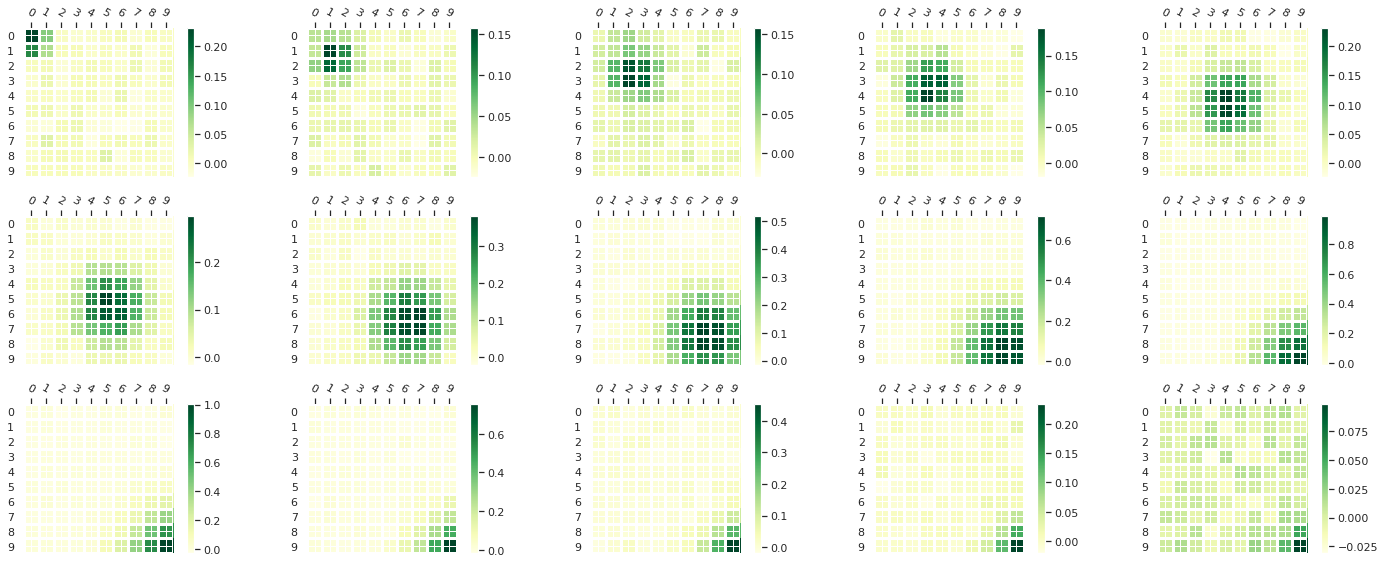

True data for t from 5 to 8:


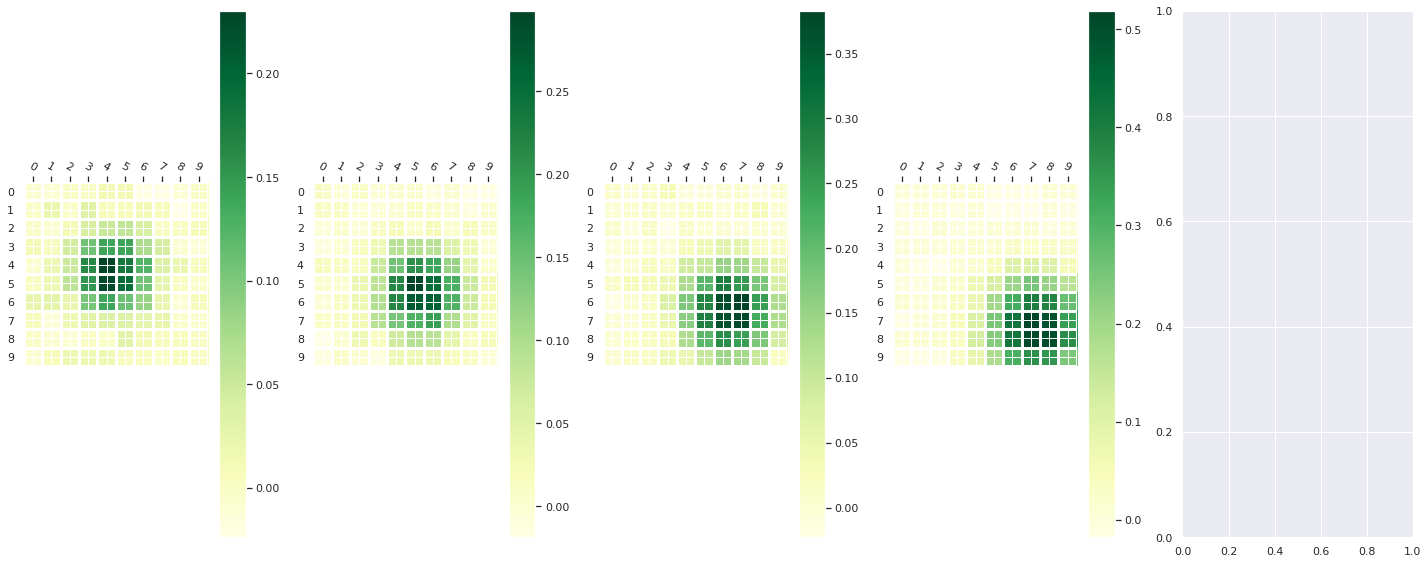

Predicted data for t from 5 to 8


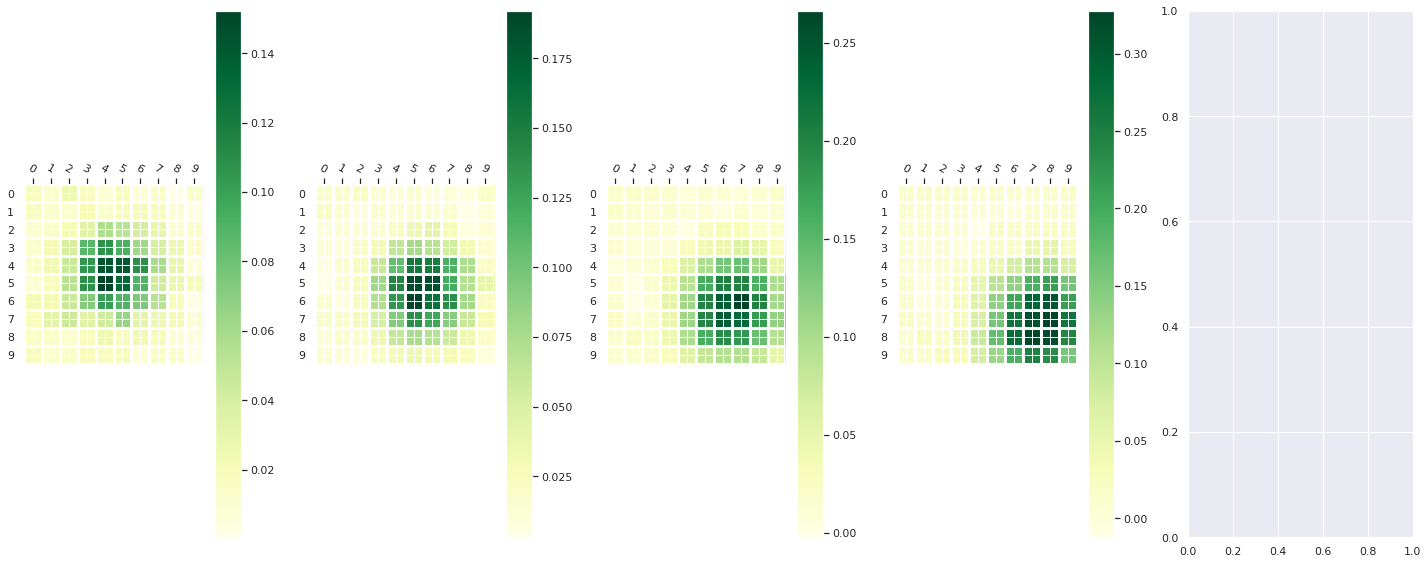

error for the new sample is 0.0015


In [13]:
# simulate data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 1
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]) == 1
baseline_underlying_mask = np.array([[1,1,0,0,0,0,0,0,0,0],
                                    [1,1,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0]]
                                   ).ravel()
baseline_underlying =(np.random.randn(total, n**2) * 4 + 10) * baseline_underlying_mask
#print(baseline_underlying)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data)




# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 2
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint if possible
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_upper_left_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

model.to(device)  # transfer model on gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, output, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break

# plot the true data
true_data = test_data.Z[0, ...].squeeze(1)
#print(true_data)

print("True evolving process:")
plot_spatio_temporal_data(true_data)
print("True data for t from 5 to 8:")
plot_spatio_temporal_data(true_data[~mask[0, :], ...])

predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
print("Predicted data for t from 5 to 8")
plot_spatio_temporal_data(predicted_data)
print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[~mask[0, :], ...])**2))


# Different baseline values, evolving 15 time steps, predict the sequence from t $\in$ {5, 7, 9, 11}
We initialize the sequence at different baseline values, only top left has non-zero values. Let it evolve 4 time steps, then predict the value at time step 5, observe time step 6, and predict time step 7, then observe 8 and predict 9, observe 10 and predict 11.
This is considered as a gap filling task, but until now, we still use the history to fit the missing values.

## Baseline value changes for every training sample
This is considered to be difficult to train the only way to fit well on this dataset is to fully capture the spatial temporal structure.

### Train and validate the model

In [9]:
# simulate the data
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 200 
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]) == 1  # mask is different from last time 
baseline_underlying_mask = np.array([[1,1,0,0,0,0,0,0,0,0],
                                    [1,1,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0]]
                                   ).ravel()
baseline_underlying =(np.random.randn(total, n**2) * 4 + 10) * baseline_underlying_mask
data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
data_module = DatasetDataModule(data, 1, 0.5)

# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_missing_values_imputing_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

#logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)         
trainer.fit(model, data_module)

# save the checkpoint
trainer.save_checkpoint("different_baseline_values_missing_values_imputing_for_each_training_sample.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | ED            | ED      | 892 K 
1 | loss_function | MSELoss | 0     
------------------------------------------
892 K     Trainable params
0         Non-trainable params
892 K     Total params
3.570     Total estimated model params size (MB)


max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Visualization 

max eigen value is 0.204281
valid initial parameters!
based on the error term, the best mse we can achieve will be above 0.0001
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
True evolving process:


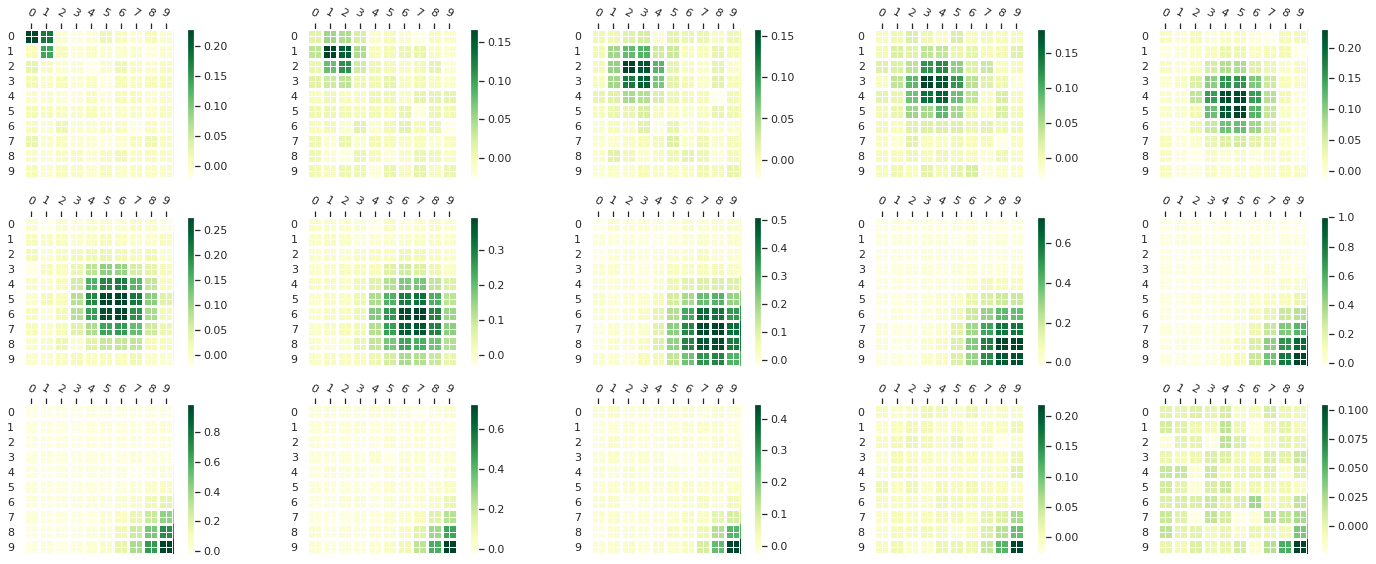

True data for t = 5, 7, 9, 11:


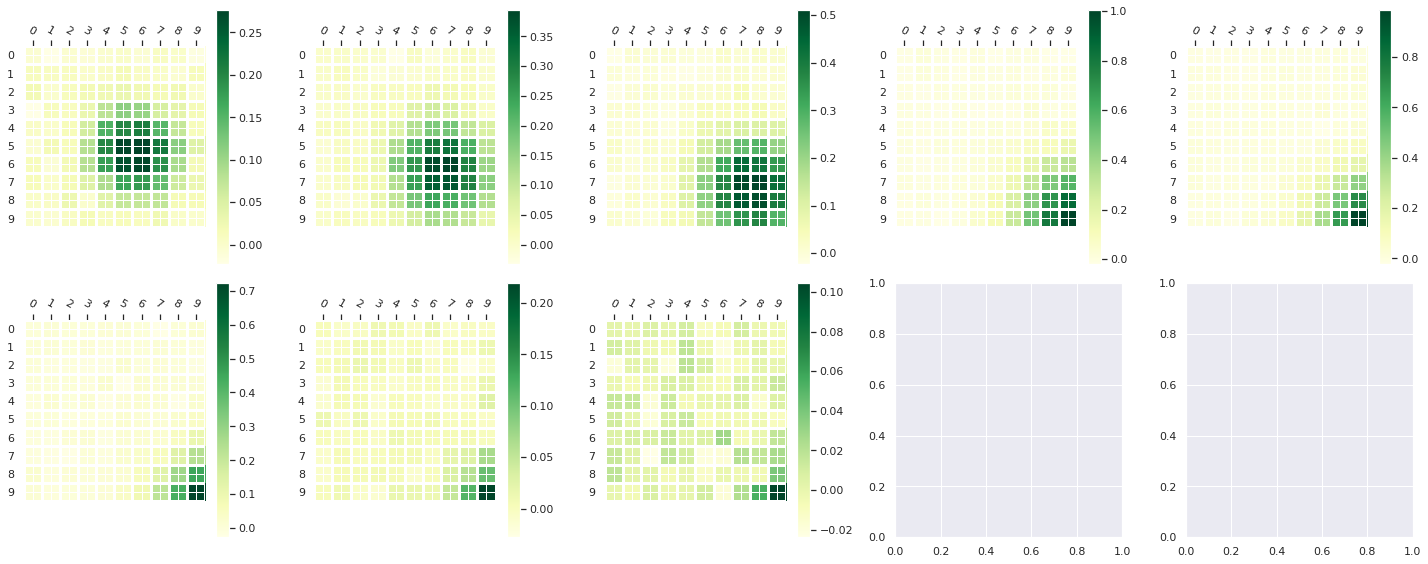

Predicted data for t = 5, 7, 9, 11


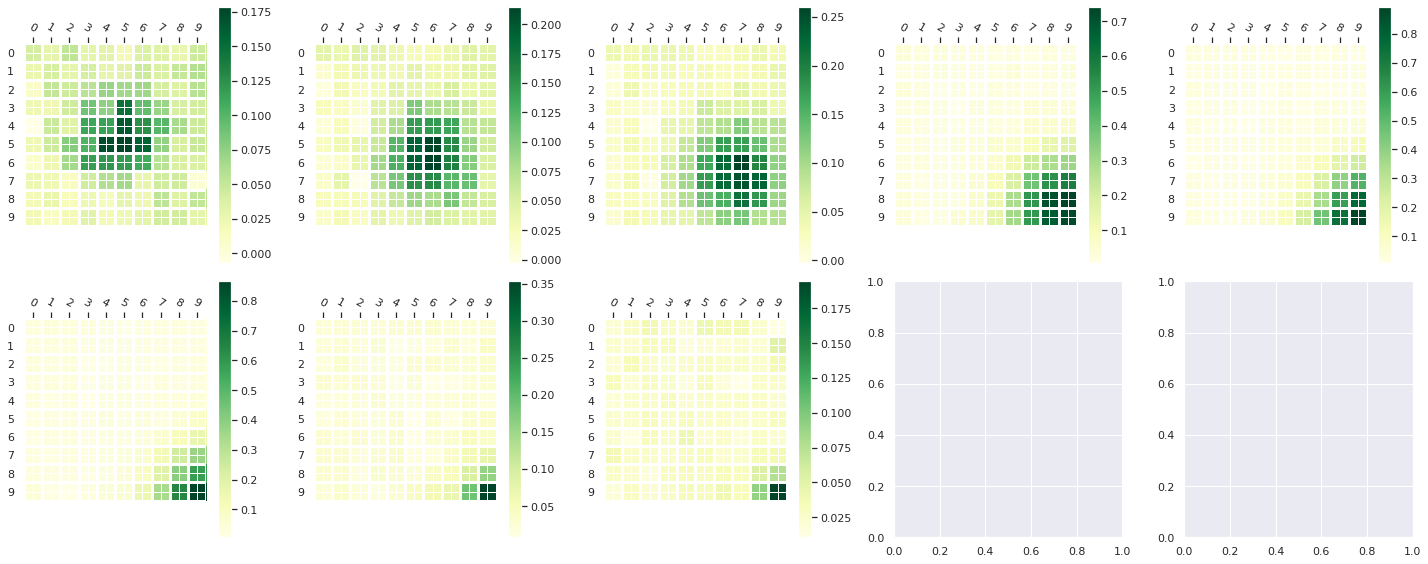

error for the new sample is 0.0031


In [11]:
# simulate data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n = 10
T = 15
theta1 = 0.5
theta2 = 1
theta3 = 1
theta4 = 1
total = 1
mask = np.ones([total, T]) * np.array([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]) == 1
baseline_underlying_mask = np.array([[1,1,0,0,0,0,0,0,0,0],
                                    [1,1,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0],
                                    [0,0,0,0,0,0,0,0,0,0]]
                                   ).ravel()
baseline_underlying =(np.random.randn(total, n**2) * 4 + 10) * baseline_underlying_mask
#print(baseline_underlying)
test_data = DatasetDstm3(n, T, theta1, theta2, theta3, theta4, total, mask, baseline_underlying)
test_data_loader = DataLoader(test_data)




# build the model
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(10, 10), input_channels=1, filter_size=3, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(10, 10), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 2
model = LightningED(ED_net, mc_dropout, learning_rate)

# load from checkpoint if possible
try:
    model.load_from_checkpoint(checkpoint_path='different_baseline_values_missing_values_imputing_for_each_training_sample.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass

model.to(device)  # transfer model on gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, output, seq_len = batch

    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break

# plot the true data
true_data = test_data.Z[0, ...].squeeze(1)
#print(true_data)

print("True evolving process:")
plot_spatio_temporal_data(true_data)
print("True data for t = 5, 7, 9, 11:")
plot_spatio_temporal_data(true_data[~mask[0, :], ...])

predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
print("Predicted data for t = 5, 7, 9, 11")
plot_spatio_temporal_data(predicted_data)
print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[~mask[0, :], ...])**2))
